<a href="https://colab.research.google.com/github/miras1109/A-Comparative-Study-of-Decision-Tree-Random-Forest-KNN-DBSCAN-and-SVM-XGBoost-for-Football-Analytics/blob/main/ass1main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Load CSV (make sure to upload to Colab first)
df = pd.read_csv("players_data-2024_2025.csv")

# Preview
print(df.head())
print("Number of rows:", df.shape[0])


   Rk             Player   Nation    Pos        Squad                Comp  \
0   1         Max Aarons  eng ENG     DF  Bournemouth  eng Premier League   
1   2         Max Aarons  eng ENG  DF,MF     Valencia          es La Liga   
2   3     Rodrigo Abajas   es ESP     DF     Valencia          es La Liga   
3   4     James Abankwah   ie IRL  DF,MF      Udinese          it Serie A   
4   5  Keyliane Abdallah   fr FRA     FW    Marseille          fr Ligue 1   

    Age    Born  MP  Starts  ...  Att (GK)  Thr  Launch%  AvgLen  Opp  Stp  \
0  24.0  2000.0   3       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
1  24.0  2000.0   4       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
2  21.0  2003.0   1       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
3  20.0  2004.0   6       0  ...       NaN  NaN      NaN     NaN  NaN  NaN   
4  18.0  2006.0   1       0  ...       NaN  NaN      NaN     NaN  NaN  NaN   

   Stp%  #OPA  #OPA/90  AvgDist  
0   NaN   NaN      NaN      NaN  


In [ ]:
# Drop rows with missing values in required columns
df = df.dropna(subset=["Age", "Gls", "Ast", "MP", "Min", "CrdY", "CrdR", "xG+xAG", "Pos"])

# Define performance scoring function
def performance_level(row):
    matches = row["MP"] if row["MP"] > 0 else 1
    score = (row["Gls"]/matches + row["Ast"]/matches + row["xG+xAG"]/10)
    if score >= 1.5:
        return "High"
    elif score >= 1.0:
        return "Medium"
    else:
        return "Low"

df["performance"] = df.apply(performance_level, axis=1)

# Remove rare classes (must have ≥2 samples for stratified split)
class_counts = df["performance"].value_counts()
df = df[df["performance"].isin(class_counts[class_counts > 1].index)]

# Encode categorical column
le = LabelEncoder()
df["Pos_encoded"] = le.fit_transform(df["Pos"])

# Features and target
features = ["Age", "Gls", "Ast", "MP", "Min", "CrdY", "CrdR", "xG+xAG", "Pos_encoded"]
X = df[features]
y = df["performance"]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Final dataset shape:", X.shape)
print("Target class distribution:\n", y.value_counts())


Final dataset shape: (2845, 9)
Target class distribution:
 performance
Low       2836
Medium       9
Name: count, dtype: int64


In [ ]:
splits = [(0.8,0.2),(0.75,0.25),(0.7,0.3),(0.65,0.35),(0.6,0.4)]
results = []
classification_reports = {}

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Loop algorithm by algorithm
for algo_name, model in models.items():
    iteration = 1
    for train_size, test_size in splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=train_size,
            test_size=test_size,
            random_state=42,
            stratify=y
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        results.append({
            "Algorithm": algo_name,
            "Iteration": iteration,
            "Features": len(features),
            "Targets": y.nunique(),
            "Train %": int(train_size*100),
            "Test %": int(test_size*100),
            "Accuracy": round(acc,4),
            "Precision": round(prec,4),
            "Recall": round(rec,4),
            "F1-Score": round(f1,4)
        })

        # Save classification report only for 80/20 split
        if train_size == 0.8:
            classification_reports[algo_name] = classification_report(y_test, y_pred, output_dict=True)

        iteration += 1


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df = pd.DataFrame(results)

# Grouped by Algorithm then Iteration
results_df = results_df.sort_values(by=["Algorithm", "Iteration"]).reset_index(drop=True)

print("\n=== Final Results Table ===")
print(results_df)

# Save to CSV for report
results_df.to_csv("ml_results.csv", index=False)



=== Final Results Table ===
        Algorithm  Iteration  Features  Targets  Train %  Test %  Accuracy  \
0   Decision Tree          1         9        2       80      20    0.9947   
1   Decision Tree          2         9        2       75      25    0.9958   
2   Decision Tree          3         9        2       70      30    0.9965   
3   Decision Tree          4         9        2       65      35    0.9960   
4   Decision Tree          5         9        2       60      40    0.9947   
5             KNN          1         9        2       80      20    0.9965   
6             KNN          2         9        2       75      25    0.9972   
7             KNN          3         9        2       70      30    0.9965   
8             KNN          4         9        2       65      35    0.9970   
9             KNN          5         9        2       60      40    0.9965   
10  Random Forest          1         9        2       80      20    0.9982   
11  Random Forest          2       

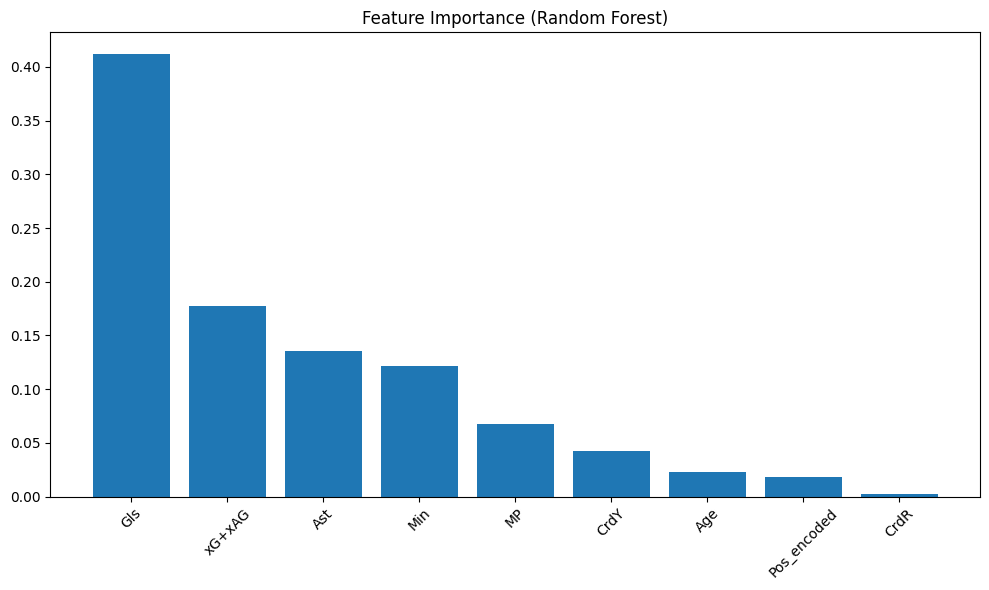

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
for model_name, report in classification_reports.items():
    print(f"\n=== Classification Report for {model_name} (80/20 split) ===")
    print(pd.DataFrame(report).transpose())



=== Classification Report for Decision Tree (80/20 split) ===
              precision    recall  f1-score     support
Low            0.996479  0.998236  0.997357  567.000000
Medium         0.000000  0.000000  0.000000    2.000000
accuracy       0.994728  0.994728  0.994728    0.994728
macro avg      0.498239  0.499118  0.498678  569.000000
weighted avg   0.992976  0.994728  0.993851  569.000000

=== Classification Report for Random Forest (80/20 split) ===
              precision    recall  f1-score     support
Low            0.998239  1.000000  0.999119  567.000000
Medium         1.000000  0.500000  0.666667    2.000000
accuracy       0.998243  0.998243  0.998243    0.998243
macro avg      0.999120  0.750000  0.832893  569.000000
weighted avg   0.998246  0.998243  0.997950  569.000000

=== Classification Report for KNN (80/20 split) ===
              precision    recall  f1-score     support
Low            0.996485  1.000000  0.998239  567.000000
Medium         0.000000  0.000000  0.